# Rule-based Classification

In this notebook, we attempt a first classification of the different activities using a rule-based system.

We investigate the significance of features extracted from the anonymized video since the 3D model has problems when the target becomes too small (far from camera).
In this approach, we only focus on 2D keypoints extracted from the video as (x,y) coordinates.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

2D keypoints are arranged in a tensor with shape (2398, 17, 2).
- 2398 = number of video frames
-   17 = number of joints identified by 3DVideoPose
-    2 = (x,y) coordinates, the origin (0,0) is the top left corner

This is the layout of the joints (the points form a skeleton with head, arms, and legs facing the camera):

<div>
<img src="./images/2d_skeleton.png" height="200px" />
</div>

## Loading the feature vector

The dataset contains the anonymized video traces of 7 activities, namely:

0. **A**: walking
1. **B**: running
2. **C**: jumping
3. **G**: wave hands
4. **H**: clapping
5. **J**: wiping
6. **K**: squatting

In [2]:
time_window = 90
num_angles = 8
X = np.empty((0, time_window, num_angles))
Y = np.empty(0)

all_activities = ["S1_A", "S1_B", "S1_C", "S1_G", "S1_H", "S1_J", "S1_K"]

for idx, activity in enumerate(all_activities):
  features = np.load(f'data/features2d_{activity}.npy')
  feature_images = np.empty((0, time_window, num_angles))

  # TEST CODE FOR FOURIER ANALYSIS
  # myangle = np.fft.fft(features[:,6] - np.mean(features[:,6]))
  # plt.plot(myangle)
  # plt.xlim((-10, 1000))
  # plt.ylim((-1000, 1000))

  # Create time sequences of feature vectors
  for line in range(features.shape[0] - time_window):
    feature_over_time = np.expand_dims(features[line:(line+time_window), ...], axis=0)
    feature_images = np.concatenate((feature_images, feature_over_time))

  labels = idx * np.ones((feature_images.shape[0]))

  print(f'{activity}: {feature_images.shape}')

  X = np.concatenate((X, feature_images))
  Y = np.concatenate((Y, labels))

S1_A: (2308, 90, 8)
S1_B: (2308, 90, 8)
S1_C: (2308, 90, 8)
S1_G: (2310, 90, 8)
S1_H: (2310, 90, 8)
S1_J: (2308, 90, 8)
S1_K: (2310, 90, 8)


In [3]:
XX = np.zeros((len(X), 3))

for idx, sample in enumerate(X):
	tmp1 = np.abs(sample[:-1, :4]-sample[1:, :4])
	tmp1[tmp1 > 180] -= 180  # unwrapping
	tmp1 = np.mean(tmp1, axis=0)
	tmp2 = np.max(sample[:,4:], axis=0) - np.min(sample[:,4:], axis=0)
	tmp2[tmp2 > 180] -= 180  # unwrapping

	XX[idx, :] = [np.mean(tmp1[2:4], axis=0), np.mean(tmp2[0:2], axis=0), np.mean(tmp2[2:4], axis=0)] #forearm, upperleg, lowerleg 

XX.shape

(16162, 3)

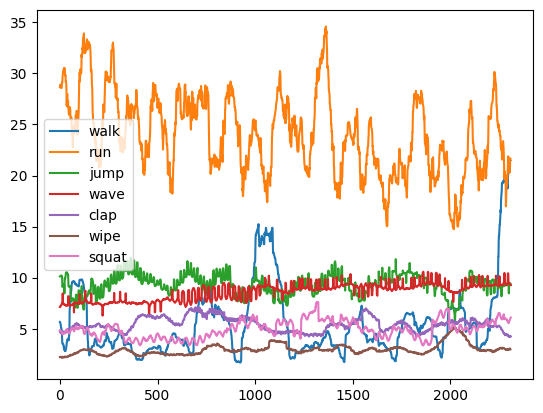

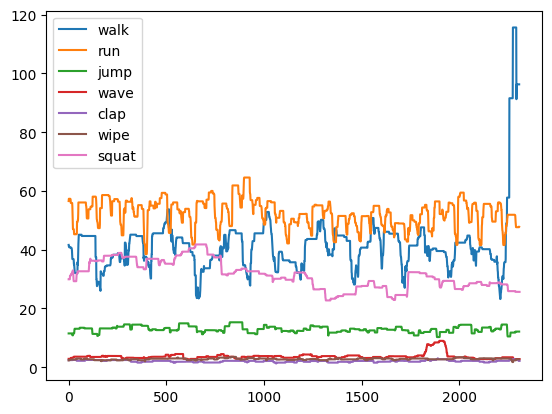

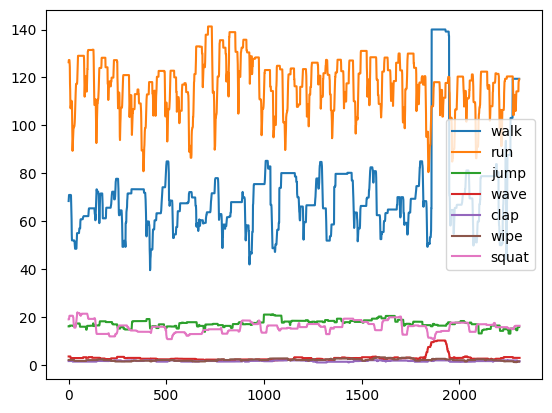

In [12]:
for feature in range(3):

	plt.plot(XX[0:2308, feature], label='walk')      # walk
	plt.plot(XX[2308:4616, feature], label='run')   # run
	plt.plot(XX[4616:6924, feature], label='jump')   # jump
	plt.plot(XX[6924:9234, feature], label='wave')   # wave
	plt.plot(XX[9234:11544, feature], label='clap')  # clap
	plt.plot(XX[11544:13852, feature], label='wipe') # wipe
	plt.plot(XX[13852:16162, feature], label='squat') # squat
	plt.legend()
	plt.show()

## Rule-based classifier

Define a classication function based on some hardcoded rules derived from the analysis of the extracted data.


In [5]:
def classifier(features):
	'''features: is a 1D vector with 3 elements
		features[0]: forearm
		features[1]: upperleg
		features[2]: lowerleg
	'''

	# Define arbitrary thresholds (from manual data analysis)
	moves_lowerleg = features[2] > 30
	moves_upperleg_lot = features[1] > 20
	moves_upperleg = features[1] > 10
	moves_forearm_lot = features[0] > 16
	moves_forearm_medium = features[0] > 7
	moves_forearm_few = features[0] > 4 and features[0] < 7 


	if moves_lowerleg:
		if moves_forearm_lot:
			return 1  # run
		else:
			return 0  # walk
	elif moves_upperleg:
		if moves_upperleg_lot:
			return 6  # squat
		else:
			return 2  # jump
	else:
		if moves_forearm_medium:
			return 3  # wave
		else:
			if moves_forearm_few:
				return 4  # clap
			else:
				return 5  # wipe

In [6]:
predicted = np.zeros(Y.shape)

for idx, sample in enumerate(XX):
    predicted[idx] = classifier(sample)
    

In [7]:
report = classification_report(Y, predicted)
cm = confusion_matrix(Y, predicted)

In [8]:
print(report)

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      2308
         1.0       0.98      0.98      0.98      2308
         2.0       1.00      1.00      1.00      2308
         3.0       0.99      0.99      0.99      2310
         4.0       0.95      0.99      0.97      2310
         5.0       1.00      0.95      0.97      2308
         6.0       1.00      1.00      1.00      2310

    accuracy                           0.99     16162
   macro avg       0.99      0.99      0.99     16162
weighted avg       0.99      0.99      0.99     16162



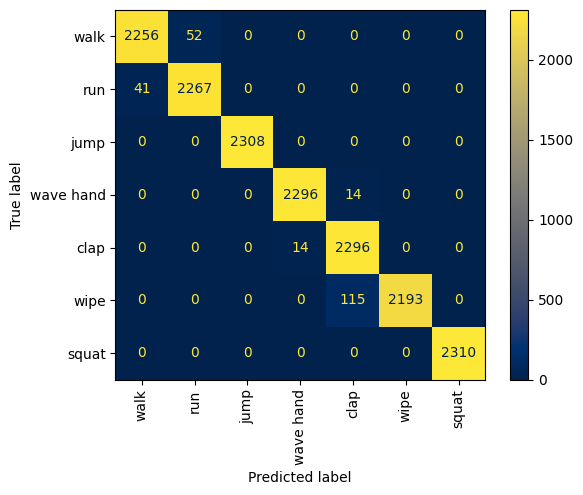

In [9]:
semantic_classes = ['walk', 'run', 'jump', 'wave hand', 'clap', 'wipe', 'squat']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=semantic_classes)
plot = disp.plot(cmap='cividis', xticks_rotation='vertical')